# IMPORTING THE LIBRARIES

In [1]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Dense, Average
from tensorflow.keras.layers import concatenate, Concatenate
from keras.regularizers import l2
from numpy import argmax
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tqdm
import random
import re
from keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

# Load the trained models - ResNet and XceptionNet

In [2]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'models/model_' + str(i + 1) + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# Load the Data

In [3]:
input_path = []
label = []
for class_name in tqdm.tqdm(os.listdir("images")):
     for path in os.listdir("images/"+class_name):
            if re.search("^id[0]_", path):
                for image_path in os.listdir("images/"+class_name+"/"+path):
                    if class_name == 'celeb-real-imgs':
                        label.append(0)
                    else: 
                        label.append(1) 
                    input_path.append(os.path.join("images", class_name, path, image_path))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.00it/s]


# DATA SHEFFLING

In [4]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,images\Celeb-synthesis-imgs\id0_id26_0005\fram...,1
1,images\Celeb-synthesis-imgs\id0_id20_0007\fram...,1
2,images\Celeb-synthesis-imgs\id0_id1_0001\frame...,1
3,images\Celeb-synthesis-imgs\id0_id26_0006\fram...,1
4,images\Celeb-synthesis-imgs\id0_id26_0003\fram...,1


In [7]:
df['label'] = df['label'].astype('str')
df.head()

,images,label
0,images\Celeb-synthesis-imgs\id0_id26_0005\fram...,1
1,images\Celeb-synthesis-imgs\id0_id20_0007\fram...,1
2,images\Celeb-synthesis-imgs\id0_id1_0001\frame...,1
3,images\Celeb-synthesis-imgs\id0_id26_0006\fram...,1
4,images\Celeb-synthesis-imgs\id0_id26_0003\fram...,1


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# LOAD THE MODELS

In [9]:
models = load_all_models(2)

>loaded models/model_1.h5
>loaded models/model_2.h5


# RESNET MODEL SUMMARY

In [10]:
# ResNet
models[0].summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

# XCEPTIONNET MODEL SUMMARY

In [11]:
# XCeptionNet
models[1].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

 block8_sepconv2_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block8_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 block8_sepconv3_act (Activatio  (None, 8, 8, 728)   0           ['block8_sepconv2_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block8_sepconv3 (SeparableConv  (None, 8, 8, 728)   536536      ['block8_sepconv3_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block8_sepconv3_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block8_sepconv3[0][0]']        
 lization)

                                                                                                  
 conv2d_3 (Conv2D)              (None, 4, 4, 1024)   745472      ['add_10[0][0]']                 
                                                                                                  
 block13_pool (MaxPooling2D)    (None, 4, 4, 1024)   0           ['block13_sepconv2_bn[0][0]']    
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 4, 4, 1024)  4096        ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add_11 (Add)                   (None, 4, 4, 1024)   0           ['block13_pool[0][0]',           
                                                                  'batch_normalization_3[0][0]']  
          

# EXTRACTION DENSE LAYERS FROM THE PRETRAINED MODELS

In [12]:
resnet_layer = models[0].get_layer('dense_1').output
xception_layer = models[1].get_layer('dense').output

# CONCATENATING THE TWO DENSE LAYERS

In [13]:
merged_layers = concatenate([resnet_layer, xception_layer], name="concatenated_layer")
merged_layers

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'concatenated_layer')>

# CREATING A OUTPUT LAYER AND ATTAHED TO CONCATENTING LAYER

In [14]:
out = Dense(512, activation='relu', name="2nd_final_output")(merged_layers)
final_output = Dense(1, activation='sigmoid', name='final_output')(out)

# CREATING A ENSEMBLE MODEL

In [15]:
merged_model = Model(inputs=[(models[0].input, models[1].input)],outputs=[final_output], name = "ensemble_m")

In [16]:
merged_model.summary()

Model: "ensemble_m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']    

In [17]:
plot_model(merged_model, "architecture.png", show_shapes=True)

# CALLBACKS 

In [18]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
# from sklearn.model_selection import train_test_split


checkpoint = ModelCheckpoint('working/Resnet50_best.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', min_delta=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)

csv_logger = CSVLogger(filename='working/training_log.csv',
                       separator=',',
                       append=True)

callbacks_list = [early, reduceLROnPlat]

# IMAGE GENERATOR

In [19]:
def generator_two_img(data):
    generator = ImageDataGenerator(
                                    rescale = 1./255,
                                    rotation_range = 40,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    fill_mode = 'nearest'
                                   )



    test_iterator_x1 = generator.flow_from_dataframe(
                                                            data,
                                                            x_col='images',
                                                            y_col='label',
                                                            target_size=(128,128),
                                                            batch_size=512,
                                                            class_mode='binary',
                                                            shuffle = False
                                                        )
    test_iterator_x2 = generator.flow_from_dataframe(
                                                            data,
                                                            x_col='images',
                                                            y_col='label',
                                                            target_size=(128,128),
                                                            batch_size=512,
                                                            class_mode='binary',
                                                            shuffle = False
                                                        )
    while True:
        X1i = test_iterator_x1.next()
        X2i = test_iterator_x2.next()
        yield [X1i[0], X2i[0]], X2i[1]

# MODEL COMPILING

In [20]:
merged_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# MODEL TRAINING

In [21]:
batch_size = 512

train_size = train.shape[0]
val_size = val.shape[0]
test_size = test.shape[0]

In [22]:
history = merged_model.fit_generator(generator_two_img(train), steps_per_epoch=train_size//batch_size, 
                           epochs=10, validation_data=generator_two_img(val), 
                           validation_steps=val_size//batch_size,
                           callbacks=callbacks_list)

Found 35187 validated image filenames belonging to 2 classes.
Found 35187 validated image filenames belonging to 2 classes.
Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9178 Found 8797 validated image filenames belonging to 2 classes.
Found 8797 validated image filenames belonging to 2 classes.
68/68 [==============================] - 3153s 46s/step - loss: 0.2752 - accuracy: 0.9178 - val_loss: 0.2772 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 2/10
68/68 [==============================] - 2863s 42s/step - loss: 0.2505 - accuracy: 0.9229 - val_loss: 0.2624 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 3/10
68/68 [==============================] - 2907s 43s/step - loss: 0.2437 - accuracy: 0.9232 - val_loss: 0.2593 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 4/10
68/68 [==============================] - 2921s 43s/step - loss: 0.2423 - accuracy: 0.9232 - val_loss: 0.2583 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 5/10
68/68 [=============================

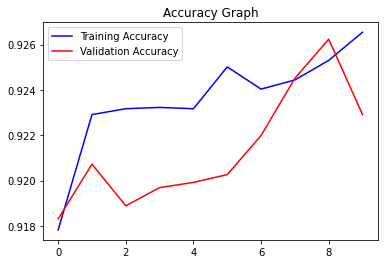

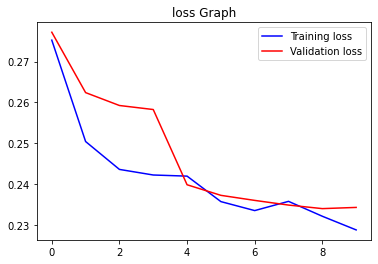

<Figure size 432x288 with 0 Axes>

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('loss Graph')
plt.legend()
plt.figure()
plt.show()

In [30]:
filename = 'concatenated_model.h5'
merged_model.save(filename)

In [31]:
merged_test_scores = merged_model.evaluate_generator(generator_two_img(test), steps=10)

Found 10996 validated image filenames belonging to 2 classes.
Found 10996 validated image filenames belonging to 2 classes.


In [32]:
merged_test_scores[1]

0.929882824420929

In [38]:
merged_model.fit_generator(generator_two_img(train), steps_per_epoch=2, 
                           epochs=3, validation_data=generator_two_img(val), 
                           validation_steps=10,
                           callbacks=callbacks_list)

Found 35187 validated image filenames belonging to 2 classes.
Found 35187 validated image filenames belonging to 2 classes.
Epoch 1/3
2/2 [==============================] - 692s 652s/step - loss: 0.2555 - accuracy: 0.9307 - val_loss: 0.2786 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 2/3
2/2 [==============================] - 618s 582s/step - loss: 0.3031 - accuracy: 0.9033 - val_loss: 0.3012 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 3/3
2/2 [==============================] - 619s 584s/step - loss: 0.2870 - accuracy: 0.9082 - val_loss: 0.3019 - val_accuracy: 0.9150 - lr: 0.0010


In [42]:
merged_test_scores

[0.2906154990196228, 0.9212890863418579]

In [21]:
merged_test_scores = merged_model.evaluate_generator(generator_two_img(test), steps=test_size//batch_size)

Found 10996 validated image filenames belonging to 2 classes.
Found 10996 validated image filenames belonging to 2 classes.


In [22]:
merged_test_scores

[0.2132594883441925, 0.9338727593421936]